In [92]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import statsmodels.api as sm
import statsmodels.tsa.api as smt

# Téma: Exponenciální vyhlazování (vyrovnávání)

Metody exponenciálního vyhlazování (exponential smoothing) jsou jedny z nejstarších, nejjednodušších a přitom velmi efektivních způsobů práce s časovými řadami. Pomocí nich je možné snadno interpolovat a extrapolovat (predikovat) vývoj řady, které mohou mít různé komponenty, včetně trendu či sezónnosti.

## Jednoduché exponenciální vyhlazování (SES)

SES - simple (či single) exponential smoothing - je základní metodou, která předpokládá **absenci trendu i sezónnosti**. Její princip vychází z následující úvahy, vycházející z dvou extrémních (naivních) přístupů:
- **Extrém 1:** všechna budoucí data (predikce) jsou rovna poslední pozorované hodnotě čas. řady $y_T$:

$$
\hat{y}_{T+h|T} = y_T, \qquad h=1,2,\ldots
$$

- **Extrém 2:** všechny budoucí (predikované) hodnoty jsou rovny aritmetickému průměru dosud pozorovaných hodnot:

$$
\hat{y}_{T+h|T} = \frac{1}{T} \sum_{t=1}^T y_t, \qquad h=1,2,\ldots
$$

První extrém říká, že budoucí pozorování jsou založena na posledním, zatímco druhý extrém zakládá predikci na všech předchozích pozorovaných hodnotách, a to se stejnými váhami $1/T$. Jednoduché exponenciální vyhlazování potom leží mezi těmito dvěma extrémy - klade větší váhy na novější data a menší váhy na data starší, přičemž vývoj vah je nelineární (exponenciální). Zaveďme průměrovací váhu - vyhlazovací parametr či faktor $\alpha\in[0,1]$ a predikce ve tvaru

$$
\begin{aligned}
\hat{y}_{T+1|T} &= \alpha y_{T} + \alpha(1-\alpha) y_{T-1} + \alpha(1-\alpha)^2 y_{T-2} + \ldots \\
&= \sum_{j=0}^{T} \alpha(1-\alpha)^j y_{T-j},
\end{aligned}
$$

kde $y_0\equiv \hat{y}_0$ je hodnota, již **musíme nějak stanovit či odhadnout**.

Výše uvedený vztah lze zapsat rekurzivně

$$
\hat{y}_{t+1|t} = \alpha y_t + (1-\alpha) \hat{y}_{t|t-1}, \qquad t=1,\ldots, T.
$$

Dosazením vidíme, že

$$
\begin{aligned}
\hat{y}_{2|1} &= \alpha y_1 + (1-\alpha) \hat{y}_0,\\
\hat{y}_{3|2} &= \alpha y_2 + (1-\alpha) \hat{y}_{2|1}\\
              &= \alpha y_2 + (1-\alpha) [\alpha y_1 + (1-\alpha)\hat{y}_0] \\
              &= \alpha y_2 + \alpha (1-\alpha) y_1 + (1-\alpha)^2,\\
              &\vdots\\
\hat{y}_{T+1|T} &=  \sum_{j=0}^{T} \alpha(1-\alpha)^j y_{T-j} \\
                &= \sum_{j=0}^{T} \alpha(1-\alpha)^j y_{T-j}.
\end{aligned}
$$

Následující tabulka ukazuje hodnoty vah pro `maxdelay` zpoždění:

In [55]:
alphas = np.array([[.2, .4, .6, .8, 1.]])
weights = alphas.copy()
max_delay = 6
index = ['y(t-0)']
title = []
for j in range(1, max_delay+1):
    weights = np.r_[weights, alphas*(1-alphas)**j]
    index.append(f'y(t-{j})')
for alpha in alphas.flatten():
    title.append(f'alpha={alpha}')
weights_df = pd.DataFrame(weights, columns=title, index=index)
weights_df

,alpha=0.2,alpha=0.4,alpha=0.6,alpha=0.8,alpha=1.0
y(t-0),0.200000,0.400000,0.600000,0.800000,1.0
y(t-1),0.160000,0.240000,0.240000,0.160000,0.0
y(t-2),0.128000,0.144000,0.096000,0.032000,0.0
y(t-3),0.102400,0.086400,0.038400,0.006400,0.0
y(t-4),0.081920,0.051840,0.015360,0.001280,0.0
y(t-5),0.065536,0.031104,0.006144,0.000256,0.0
y(t-6),0.052429,0.018662,0.002458,0.000051,0.0


### Komponentní forma

Namísto zápisu predikcí $\hat{y}_{t+h|t}$ ve formě vážených průměrů se častěji využívá zápis komponentní. Ten je totiž flexibilnější, umožní snadnější vložení dalších komponent jako trendu či sezónnosti.

Označme aktuální "hladinu" - **level** $l_t$. Komponentní model má tvar

$$
\begin{alignat}{2}
\text{Forecast eq.}&&\qquad \hat{y}_{t+h|t} &= l_t, \\
\text{Smoothing eq.}&&\qquad l_t &= \alpha y_t + (1 - \alpha) l_{t-1}.
\end{alignat}
$$

Nastavením $h=1$ dostáváme jednokrokovou předpověď (včetně interpolací) a $t=T$ vede na predikce budoucích hodnot za horizontem již existujích dat $T$. Substitucí $\hat{y}_{t+1|t}$ resp. $\hat{y}_{t|t-1}$ za $l_t$ resp. $l_{t-1}$ dostaneme dříve uvedené vážené průměry. Jde tedy o ekvivalentní zápis. Jeho výhodnost uvidíme ve vícekomponentních modelech.

### Volba $l_0$ a $\alpha$

Existuje celá řada způsobů, jak vhodně zvolit vyhlazovací parametr $l_0$ a $\alpha$. Jednou z možností pro volbu $l_0$ je využít historická data, spočítat jejich průměr a použít jej. Podobně lze heuristicky přistoupit k volbě $\alpha$. Matematicky podloženější a spolehlivější je odhadnout tyto hodnoty např. metodou nejmenších čtverců, a sice minimalizací součtu kvadratických chyb predikce

$$
\text{SSE}\, = \sum_{t=1}^T (y_t - \hat{y}_{t|t-1})^2.
$$

Narozdíl od regrese, kde je lineární vztah mezi všemi regresory a regresandy naráz, má exponenciální vyhlazování rekurzivní charakter. Optimalizace tedy není lineární a je potřeba využít vhodných optimalizačních technik (či softwaru).

### Příklad na SES

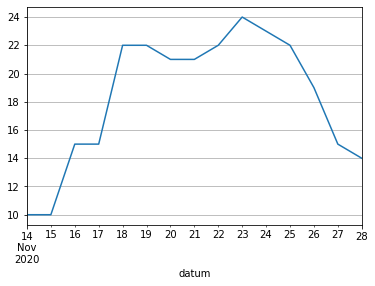

In [176]:
url = 'https://onemocneni-aktualne.mzcr.cz/api/v2/covid-19/orp.csv'
#fn = 'data/covid-listopad.csv'
data = pd.read_csv(url, parse_dates=[1], index_col=1)
orp = data.loc[data['orp_nazev'] == 'Soběslav']
data = orp['aktualni_pocet_hospitalizovanych_osob'].last('15D') #loc['2020-11':]
data.plot()

/usr/lib/python3/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


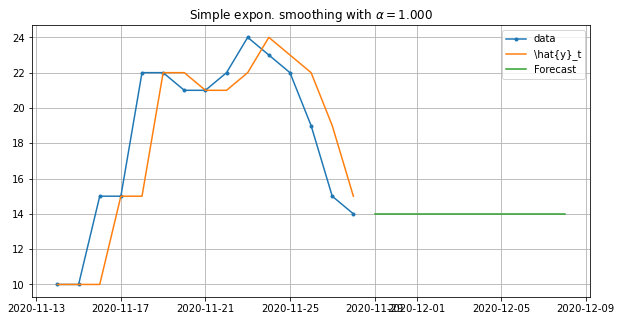

In [177]:
alpha = .8
#method = smt.SimpleExpSmoothing(data, initialization_method="heuristic")
#fit = method.fit(smoothing_level=alpha,optimized=False)
method = smt.SimpleExpSmoothing(data, initialization_method="heuristic")
fit = method.fit()
fcast = fit.forecast(10)

plt.figure(figsize=(10, 5))
plt.title(fr"Simple expon. smoothing with $\alpha = {fit.model.params['smoothing_level']:.3f}$")
plt.plot(data, marker='.', label='data')
plt.plot(fit.fittedvalues, label='\hat{y}_t')
plt.plot(fcast, label='Forecast')
plt.legend()
plt.show()

## Dvojité exponenciální vyhlazování

Dvojité exponenciální vyhlazování - DES (double ES) - je rozšířením SES na časové řady s trendem. DES metod je větší množství, my si představíme dvě, a to Holtovu metodu s lineárním trendem a metodu s tlumeným trendem.

### Holtova metoda s lineárním trendem

Tato metoda má následující komponentní formu:

$$
\begin{alignat}{2}
\text{Forecast eq.}&&\qquad \hat{y}_{t+h|t} &= l_t + hb_t, \\
\text{Level eq.}&&\qquad l_t &= \alpha y_t + (1 - \alpha)(l_{t-1} + b_{t-1},\\
\text{Trend eq.}&&\qquad b_t &= \beta^{*}(l_t - l_{t-1}) + (1 - \beta^{*})b_{t-1},
\end{alignat}
$$

kde $l_t$ je level (hladina) časové řady v čase $t$, $b_t$ je odhad směrnice trendu v čase $t$, parametry $\alpha, \beta^* \in [0, 1]$ jsou vyhlazovací paramety. Pozorným čtením rovnic zjistíme, že ono "druhé" vyhlazování běží na trendu (ověřte intuitivně!).

### Holtova metoda s tlumeným trendem

Jistou nevýhodou této základní metody je invariance trendu, který je buď do nekonečna rostoucí, nebo klesající. Jelikož dlouhodobé předpovědi tohoto modelu mají tendence nadhodnocovat budoucí hodnoty, byl navržen model, který trend utlumuje. Výsledkem je model rozšířený o tlumící parametr $\phi \in(0,1]$, přičemž hodnota $\phi=1$ vede na základní Holtovu metodu s lin. trendem. Komponentní forma modelu je následující:

$$
\begin{alignat}{2}
\text{Forecast eq.}&&\qquad \hat{y}_{t+h|t} &= l_t + (\phi + \phi^2 + \cdots + \phi^h) b_t, \\
\text{Level eq.}&&\qquad l_t &= \alpha y_t + (1 - \alpha)(l_{t-1} + \phi b_{t-1},\\
\text{Trend eq.}&&\qquad b_t &= \beta^{*}(l_t - l_{t-1}) + (1 - \beta^{*})\phi b_{t-1}.
\end{alignat}
$$

Lze ukázat, že krátkodobé předpovědi mají tlumený trend a dlouhodobé konvergují k netrendovým, tj. konstantním hodnotám $l_T + \phi b_T/(1-\phi)$. V praxi jsou nejčastěji hodnoty $\phi \in [0.8, 0.98]$.

/usr/lib/python3/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


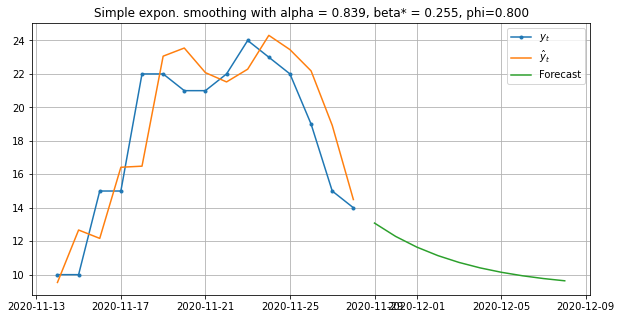

In [191]:
method = smt.ExponentialSmoothing(data, initialization_method="estimated", 
                                  trend='add', damped_trend=True, seasonal=None)
fit = method.fit()
fcast = fit.forecast(10)

plt.figure(figsize=(10, 5))
plt.title(rf"Simple expon. smoothing with alpha = {fit.model.params['smoothing_level']:.3f}, " 
         + fr"beta* = {fit.model.params['smoothing_trend']:.3f}, "
         + fr"phi={fit.model.params['damping_trend']:.3f}")
plt.plot(data, marker='.', label=r'$y_t$')
plt.plot(fit.fittedvalues, label=r'$\hat{y}_t$')
plt.plot(fcast, label='Forecast')
plt.legend()
plt.show()

## Trojité exponenciální vyhlazování (Holtova-Wintersova metoda)

Holtova-Wintersova metoda se sestává ze tří vyhlazovacích rovnic, jedné pro hladinu (level) $l_t$, jedné pro trend $b_t$ a jedné pro sezónní komponentu $s_t$. Ke každé složce potom náleží odpovídající vyhlazovací parametr $\alpha, \beta^*$ a $\gamma$, všechny teoreticky z intervalu $[0, 1]$. Označme písmenem $m$ sezónnost, podobně jako jsme to dělali u SARIMA modelů (akorát tam bylo $s$).

Metoda má svou aditivní a multiplikativní variantu, podle toho, zda jsou sezónní variace (typicky amplituda) konstantní, nebo se mění v závislosti na čase (viz 1. přednáška).

### Aditivní metoda
Aditivní metoda předpokládá, že sezónní složky jsou prakticky stejné a sčítají se (přibližně) do nuly. Model má tvar

$$
\begin{alignat}{2}
\text{Forecast eq.}&&\qquad \hat{y}_{t+h|t} &= l_t + hb_t + s_{t+h-m(k+1)}, \\
\text{Level eq.}&&\qquad l_t &= \alpha (y_t - s_{t-m} + (1 - \alpha)(l_{t-1} + b_{t-1},\\
\text{Trend eq.}&&\qquad b_t &= \beta^{*}(l_t - l_{t-1}) + (1 - \beta^{*})b_{t-1}, \\
\text{Seasonal eq.} &&\qquad s_t &= \gamma(y_t - l_{t-1} - b_{t-1}) + (1-\gamma)s_{t-m},
\end{alignat}
$$

kde $k = \lfloor (h-1)/m \rfloor$. Poslední z rovnic vyjadřuje vážený průměr mezi současnou hodnotou sezónnosti (sezónního indexu) a téže veličinou v předchozí sezóně.

### Multiplikativní metoda
Multiplikativní metoda předpokládá, že sezónní složky se mění v závislost na hladině $l_t$. Sezónní komponenta je v modelu vyjádřena jako relativní (procentuální) veličina, srov. s aditivním modelem. Komponentní forma má tvar

$$
\begin{alignat}{2}
\text{Forecast eq.}&&\qquad \hat{y}_{t+h|t} &= (l_t + hb_t)s_{t+h-m(k+1)}, \\
\text{Level eq.}&&\qquad l_t &= \alpha \frac{y_t}{s_{t-m}} + (1 - \alpha)(l_{t-1} + b_{t-1},\\
\text{Trend eq.}&&\qquad b_t &= \beta^{*}(l_t - l_{t-1}) + (1 - \beta^{*})b_{t-1}, \\
\text{Seasonal eq.} &&\qquad s_t &= \gamma \frac{y_t}{l_{t-1} + b_{t-1}} + (1-\gamma)s_{t-m}.
\end{alignat}
$$

V rovnici pro hladinu (level) $l_t$ a v sezónní rovnici vidíme zmíněnou relativní hodnotu.

## ETS modely

ETS (error - trend - seasonal) modely jsou modely exponenciálního vyhlazování zapsané v podobě **stavových rovnic**. Na základě kombinací komponent rozlišujeme několik základních modelů. Zavedeme-li:
- **E**rror $\in$ {**A**dditive, **M**ultiplicative}m
- **T**rend $\in$ {**N**one, **A**dditive, **A**dditive **d**amped}
- **S**easonal $\in$ {**N**one, **A**dditive, **M**ultiplicative}

můžeme definovat modely jako 
- ETS(A,N,N) - jednoduché exponenciální vyhlazování s aditivními chybami, 
- ETS(A,A,N) - Holtova lineární metoda s aditivními chybami,
- ETS(A,A,M) - Holtova-Wintersova aditivní metoda
- a spoustu jiných.

Pro modely v podobě stavových rovnic používáme některou z již představených technik odhadu, typicky Kalmanův filtr. Další z výhod ETS modelů oproti metodám exponenciálního vyhlazování je možnost využít informační kritéria (AIC, BIC...) k porovnávání modelů.

Bodové predikce z ETS modelů a z ekvivalentních metod exponenciálního vyhlazování budou z principu vycházet stejně. Výhoda ETS modelů ovšem spočívá v jejich statistickém pohledu na šum. Díky tomu lze kvantifikovat neurčitosti spojené s odhady a predikcemi, což umožňuje vykreslovat i predikční **intervaly spolehlivosti**. Jelikož jsme s problematikou stavových modelů a jejich filtrace a predikce dostatečně obeznámeni, nebudeme se tímto tématem hlouběji zaobírat.

### Příklad: ETS(A,N,N)
Vzpomeňme na jednoduché exponenciální vyhlazování (SES) s komponentním modelem

$$
\begin{alignat}{2}
\text{Forecast eq.}&&\qquad \hat{y}_{t+h|t} &= l_t, \\
\text{Smoothing eq.}&&\qquad l_t &= \alpha y_t + (1 - \alpha) l_{t-1}.
\end{alignat}
$$

Přepíšeme-li druhou rovnici do podoby

$$
\begin{aligned}
l_t &= l_{t-1} + \alpha(y_t - l_{t-1}) \\
    &= l_{t-1} + \alpha \varepsilon_{t},
\end{aligned}
$$

kde $\varepsilon_t$ je chyba (reziduum) predikce, můžeme rovněž zapsat aktuální pozorování jako součet předchozí hladiny plus chyba predikce,

$$
y_t = l_{t-1} + \varepsilon_t.
$$

Zřejmě tedy můžeme komponentní model vyjádřit i v podově stavového modelu

$$
\begin{aligned}
y_t &= l_{t-1} + \varepsilon_t, \\
l_t &= l_{t-1} + \alpha\varepsilon_t,
\end{aligned}
$$

kde $\varepsilon_t$ jsou aditivní a nezávislá, ideálně centrované v nule a s konstantní variancí, tedy iid $\varepsilon \sim \mathcal{N}(0, \sigma^2)$. Za povšimnutí stojí, že $\alpha = 0$ vede na náhodnou procházku.

/usr/lib/python3/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


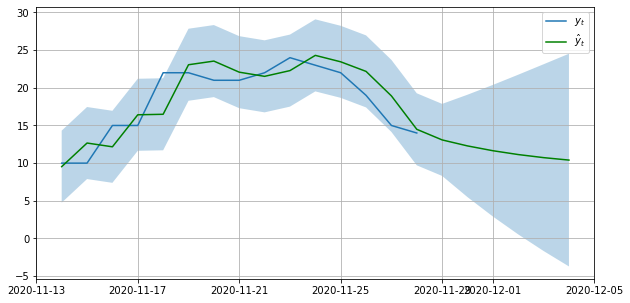

In [195]:
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
model = ETSModel(data.astype('float64'), error='add', trend='add', damped_trend=True,
                 initialization_method='estimated')
fit = model.fit(disp=True)
preds = fit.get_prediction(end=len(data)+5)
preds_df = preds.summary_frame()

plt.figure(figsize=(10,5))
plt.plot(data, label=r'$y_t$')
plt.plot(preds_df['mean'], label=r'$\hat{y}_t$', color='green')
plt.fill_between(preds_df.index, preds_df['pi_lower'],
                preds_df['pi_upper'], alpha=0.3)
plt.legend()
plt.show()

In [194]:
print(fit.summary())

                                           ETS Results                                           
Dep. Variable:     aktualni_pocet_hospitalizovanych_osob   No. Observations:                   15
Model:                                         ETS(AAdN)   Log Likelihood                 -35.212
Date:                                   Sat, 28 Nov 2020   AIC                             78.423
Time:                                           19:37:25   BIC                             81.256
Sample:                                       11-14-2020   HQIC                            78.393
                                            - 11-28-2020   Scale                            6.405
Covariance Type:                                  approx                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
smoothing_level     0.9181      0.349      2.633

## Exponenciální vyhlazování, ETS a modely ARIMA

Lze ukázat, že jednoduché exponenciální vyhlazování je ekvivalentní k modelu ARIMA(0,1,1). Vezměme pro jednoduchost stavové rovnice ETS(A,N,N), spojme je a zjednodušme $\hat{y}_{t+1|t} = \hat{y}_{t+1}$. Potom

$$
\hat{y}_{t+1} = l_t = l_{t-1} + \alpha \varepsilon_{t} = \hat{y}_{t} + \alpha \varepsilon_t.
$$

Jelikož

$$
\varepsilon_t = y_t - l_{t-1} = y_t - \hat{y}_t,
$$

dosazením do předchozí rovnice dostáváme

$$
\begin{aligned}
\hat{y}_{t+1} &= \hat{y}_t + \alpha (y_t - \hat{y}_t) \\
              &= - \varepsilon_t + y_t + \alpha (y_t - \hat{y}_t) \\
              &= y_t + (\alpha - 1)\varepsilon_{t}.
\end{aligned}
$$

Posunem v čase o krok zpět dostáváme ARIMA(0,1,1) model pro diference:

$$
\hat{y}_{t} - y_t = \theta \varepsilon_{t-1}, \qquad \text{kde}\ \theta = (\alpha-1).
$$

Podobně je Holtův-Wintersův aditivní model modelem ARIMA(0,2,2). V této přednášce se tedy spojily všechny možné přístupy k časovým řadám - ARIMA modely, stavové modely odhadované Kalmanovým filtrem a metody, které jsou sice heuristické, ale mají interpretaci modelů časořadových i stavových.

## Doporučená literatura

Tato přednáška byla ve značné míře založena na skvěle čitelném textu [Hyndman, Rob J., and George Athanasopoulos. Forecasting: principles and practice. OTexts, 2014.](https://www.otexts.org/fpp/7)

Některé zajímavé informace o exp. vyhlazování (nicméně ne podrobnosti) popisuje dobře i kniha *Koopman & Durbin: Time Series Analysis by State-Space Methods.*